**TODO: put (parts of) this into paper and/or README.**

How parameter tuning works in our case:

Each evaluator has one or two numerical parameters that can be "tuned" in order to minimize a certain error. However, we have no mathematical model that can be trained in the classical ML sense. Instead, for every service, we try parameters from a parameter grid and consider this as "training" or "tuning".

We train the parameters using a 5-fold cross validation and report the average error on the test sets as the optimal error that can be achieved.

To make the tuning comparable across services, we randomly select a constant number of parameters for each service; we then repeat the 5-fold CV 10 times to make sure that the results are stable. 

In [34]:
import pandas as pd
import numpy as np
from collections import OrderedDict, Counter
from evaluators import *
from evaluator import *
from helpers import REGISTERED_EVALUATORS

import matplotlib.ticker as mtick
from mpltools import style
style.use('ggplot')
from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Users/helena.mihaljevic-br/.virtualenvs/name-based-inference/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'shuffle', 'style', 'axes', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Compute errors without tuning

In [35]:
def compute_all_errors_without_tuning():
    service_to_all_errors = {}
    error_names = ['error_with_unknown', 'error_without_unknown', 'error_gender_bias', 'error_unknown', 
                  'weighted_error']
    
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        eval_name = evaluator.gender_evaluator
        evaluator.load_data(evaluated=True)
        evaluator._translate_api_response()
        evaluator.compute_confusion_matrix(evaluator.test_data)
        errors = evaluator.compute_all_errors()
        service_to_all_errors[eval_name] = errors
    all_errors = pd.DataFrame.from_dict(service_to_all_errors, orient='index')
    all_errors.columns = error_names
    return all_errors

In [36]:
errors_without_gender_bias = ['error_with_unknown', 'error_without_unknown', 'error_unknown', 'weighted_error']

In [37]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning().sort_index()

df.style.background_gradient(cmap=cm)

,error_with_unknown,error_without_unknown,error_gender_bias,error_unknown,weighted_error
gender_api,0.0789064,0.0503122,-0.0110616,0.030109,0.0548192
gender_api_full,0.197958,0.0698374,-0.0216737,0.13774,0.087766
gender_guesser,0.222357,0.0264298,0.00216638,0.201246,0.0613601
genderize_io,0.142758,0.0502301,0.0222393,0.0974217,0.0648209
names_api,0.230836,0.0407855,0.00712128,0.198131,0.0723309
names_api_full,0.179443,0.0342159,0.00366599,0.150372,0.0591452
namsor,0.128223,0.0429331,0.00721884,0.0891158,0.0569303


In [38]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = compute_all_errors_without_tuning().sort_index()
df = df[errors_without_gender_bias]

df.style.background_gradient(cmap=cm)

,error_with_unknown,error_without_unknown,error_unknown,weighted_error
gender_api,0.0789064,0.0503122,0.030109,0.0548192
gender_api_full,0.197958,0.0698374,0.13774,0.087766
gender_guesser,0.222357,0.0264298,0.201246,0.0613601
genderize_io,0.142758,0.0502301,0.0974217,0.0648209
names_api,0.230836,0.0407855,0.198131,0.0723309
names_api_full,0.179443,0.0342159,0.150372,0.0591452
namsor,0.128223,0.0429331,0.0891158,0.0569303


## Plot distributions of the tuning parameters

Seaborn does not work with matplotlib subplots and its own grids are not applicable here. Matplotlib on the other hand has no good plots of bivariate distributions. Hence plotting each of the seven distributions separately...

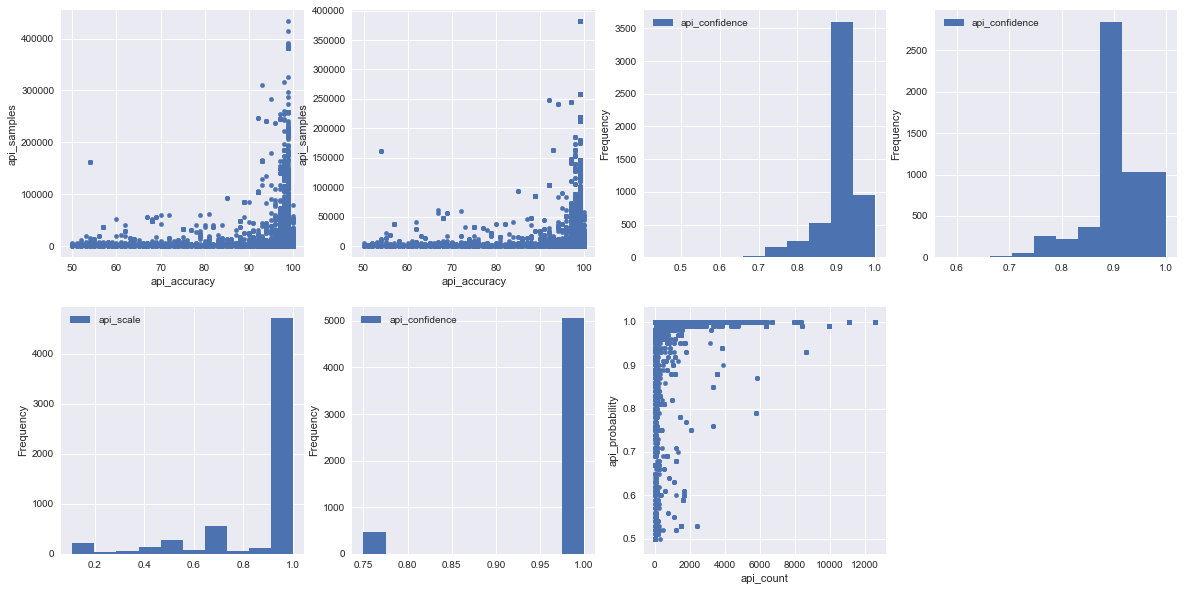

In [39]:
rows = 2
cols = 4
fs=18
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 10))
cmap = plt.get_cmap('PuRd')

i = 0
for row in range(rows):
    for col in range(cols):
        if i <= 6:
            s = REGISTERED_EVALUATORS[i]
            evaluator = s('all')
            evaluator.load_data(evaluated=True)
            evaluator.preprocess_tuning_params()
            evaluator._translate_api_response()
            evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

            if len(evaluator.tuning_params) == 1:
                evaluator.test_data[evaluator.tuning_params].plot(ax=axes[row,col], kind='hist')
            else:
                param_1, param_2 = evaluator.tuning_params[0], evaluator.tuning_params[1]
                evaluator.test_data.plot.scatter(ax=axes[row,col], x=param_1,  y=param_2)

            i += 1
        else:
            axes[-1, -1].axis('off')


## Random parameter sampling for all services

In [40]:
# sample usage
s = REGISTERED_EVALUATORS[0]
evaluator = s('all')
eval_name = evaluator.gender_evaluator
evaluator.load_data(evaluated=True)
evaluator.preprocess_tuning_params()
evaluator._translate_api_response()
evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

evaluator.sample_parameters(n_iter=3)

[{'api_accuracy': 78, 'api_samples': 121922},
 {'api_accuracy': 92, 'api_samples': 39712},
 {'api_accuracy': 100, 'api_samples': 24},
 {'api_accuracy': 96, 'api_samples': 383},
 {'api_accuracy': 99, 'api_samples': 219085},
 {'api_accuracy': 74, 'api_samples': 58},
 {'api_accuracy': 98, 'api_samples': 20},
 {'api_accuracy': 98, 'api_samples': 9},
 {'api_accuracy': 98, 'api_samples': 3030},
 {'api_accuracy': 0, 'api_samples': 0}]

In [41]:
def sample_parameters_for_all_services(n_iter=20, method='square', random_state=None):
    service_to_param_range = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator.load_data(evaluated=True)
        evaluator.preprocess_tuning_params()
        evaluator._translate_api_response()
        evaluator.remove_rows_with_unknown_gender(gender=False, gender_infered=True)
        
        service_to_param_range[evaluator.gender_evaluator] = evaluator.sample_parameters(n_iter=n_iter, 
                                                                                         method=method, 
                                                                                         random_state=random_state)
        
    return service_to_param_range

In [42]:
grid_20_20 = sample_parameters_for_all_services(n_iter=20, method="constant")
grid_30_30 = sample_parameters_for_all_services(n_iter=30, method="constant")
grid_50_50 = sample_parameters_for_all_services(n_iter=50, method="constant")
grid_100_100 = sample_parameters_for_all_services(n_iter=100, method="constant")
grid_200_200 = sample_parameters_for_all_services(n_iter=200, method="constant")

grid_20_400 = sample_parameters_for_all_services(n_iter=20, method="square")

In [43]:
# check size of grid per service
dict_of_grids = {"a: 20-20": grid_20_20, "b: 30-30": grid_30_30, "c: 50-50": grid_50_50, 
                             "d: 100-100": grid_100_100, "e: 200-200": grid_200_200, "f: 20-400": grid_20_400}

dict_of_grids = OrderedDict(sorted(dict_of_grids.items(), key=lambda t: t[0]))

for grid_size, service_to_grid in dict_of_grids.items():
    print(grid_size)
    for service, grid in service_to_grid.items():
        print(service, len(grid))

a: 20-20
genderize_io 21
gender_api 21
names_api_full 15
namsor 8
names_api 12
gender_api_full 21
gender_guesser 2
b: 30-30
genderize_io 31
gender_api 31
names_api_full 21
namsor 8
names_api 17
gender_api_full 31
gender_guesser 3
c: 50-50
genderize_io 48
gender_api 50
names_api_full 26
namsor 11
names_api 27
gender_api_full 51
gender_guesser 3
d: 100-100
genderize_io 92
gender_api 99
names_api_full 51
namsor 15
names_api 57
gender_api_full 99
gender_guesser 3
e: 200-200
genderize_io 172
gender_api 198
names_api_full 84
namsor 25
names_api 78
gender_api_full 200
gender_guesser 3
f: 20-400
genderize_io 317
gender_api 384
names_api_full 14
namsor 11
names_api 16
gender_api_full 380
gender_guesser 3


We see the following:

* for `gender_guesser` there are at most 3 parameter values anyway so exhaustive search of parameter space is reached
* the `namsor` parameter space is quite sparse, hence the grid size does not grow as fast; the other 1-parameter service `names_api` (and `names_api_full`) profits more
* the grid sizes for the 2-parameter services `gender_api` (and `gender_api_full`) and `genderize_io` grow almost to the limit of the allowed grid size

In [44]:
grid_20_20['gender_api']

[{'api_accuracy': 98, 'api_samples': 13207},
 {'api_accuracy': 96, 'api_samples': 787},
 {'api_accuracy': 98, 'api_samples': 195},
 {'api_accuracy': 100, 'api_samples': 67797},
 {'api_accuracy': 99, 'api_samples': 121922},
 {'api_accuracy': 97, 'api_samples': 57688},
 {'api_accuracy': 99, 'api_samples': 145540},
 {'api_accuracy': 100, 'api_samples': 2695},
 {'api_accuracy': 99, 'api_samples': 25872},
 {'api_accuracy': 92, 'api_samples': 4818},
 {'api_accuracy': 74, 'api_samples': 129177},
 {'api_accuracy': 99, 'api_samples': 16310},
 {'api_accuracy': 94, 'api_samples': 42667},
 {'api_accuracy': 99, 'api_samples': 59951},
 {'api_accuracy': 77, 'api_samples': 34244},
 {'api_accuracy': 99, 'api_samples': 176},
 {'api_accuracy': 99, 'api_samples': 97659},
 {'api_accuracy': 60, 'api_samples': 362},
 {'api_accuracy': 100, 'api_samples': 15399},
 {'api_accuracy': 99, 'api_samples': 211741},
 {'api_accuracy': 0, 'api_samples': 0}]

In [45]:
grid_20_20['gender_guesser']

[{'api_confidence': 1.0}, {'api_confidence': 0}]

## Benchmark by repeated cross validation

The larger the number of parameter values the smaller the error on the train set. however, choosing too many parameter values makes it harder to compare services with very few parameters and those with many, and it increases the probability of overfitting.

Hence we choose rather small parameter lists but repeat the 5-fold cross validation 10 times and count, who came first (second) how often. This ensures higher stability in the results.

In [46]:
# Wrapper around some methods to make tuning with different error functions a one-liner
def prepare_for_tuning(e):
    e.load_data(evaluated=True)
    e.preprocess_tuning_params()
    e._translate_api_response()
    e.remove_rows_with_unknown_gender(gender=True, gender_infered=False)
    e.shuffle_data()
    return e

def tune(error_func, param_ranges, constraint_func=None, constraint_val=None, verbose=True):
    service_to_test_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        print(evaluator_name)

        evaluator = prepare_for_tuning(evaluator)
        
        param_range = param_ranges[evaluator_name]
        mean_test_error = evaluator.compute_k_fold_cv_score(n_splits=5, param_range=param_range, error_func=error_func, 
                                                    constraint_func=constraint_func, constraint_val=constraint_val, 
                                                    verbose=verbose)
        service_to_test_error[evaluator_name] = mean_test_error
    return service_to_test_error

def tune_repeat(error_func, n_params, n_repeat=10, constraint_func=None, constraint_val=None, verbose=False):
    service_to_test_error_repeat = []
    for i in range(n_repeat):
        param_ranges = sample_parameters_for_all_services(n_iter=n_params, method='constant', random_state=i)
        service_to_test_error = tune(error_func, param_ranges, constraint_func=constraint_func, 
                                                  constraint_val=constraint_val, verbose=verbose)
        service_to_test_error_repeat.append(list(sorted(service_to_test_error.items(), key=lambda t: t[1])))
    return service_to_test_error_repeat

def explore_benchmark(benchmark):
    """Determine services that made it to the first and second place, and create dataframe with their CV errors 
    in each of the repetitions."""
    first_service, second_service = [], []
    for i, item in enumerate(benchmark):
        # print("first place in iteration round ", i, " :", item[0])
        # print("second place in iteration round ", i, " :", item[1])
        first_service.append(item[0][0])
        second_service.append(item[1][0])

    errors_per_service_and_iteration = pd.DataFrame.from_dict([{i[0]:i[1] for i in item} for item in benchmark])

    print("Services at place 1:", Counter(first_service))
    print("Services at place 2:", Counter(second_service))
    display(errors_per_service_and_iteration)
    return errors_per_service_and_iteration

### Benchmark 1: minimize `error_with_unknown` with the constraint  `error_without_unknown < 0.05`
This benchmark means that the error of classifying women as men or 'unknown' and classifying men as women or 'unknown' is to be minimized, under the constraint that at most 5% of those classified as men or women have been missclassified.

In [47]:
benchmark_1 = tune_repeat(error_func=Evaluator.compute_error_with_unknown, n_params=30, n_repeat=10, 
                          constraint_func=Evaluator.compute_error_without_unknown, constraint_val=0.05, verbose=True)

gender_api
minimal train error: 0.0809173517958 corresponding test error: 0.0708729472774
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0899848583171 corresponding test error: 0.110726643599
params for lowest train error: {'api_samples': 3438, 'api_accuracy': 66}
minimal train error: 0.0852260436946 corresponding test error: 0.0813148788927
params for lowest train error: {'api_samples': 95042, 'api_accuracy': 56}
minimal train error: 0.0793685121107 corresponding test error: 0.0770562770563
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.0791522491349 corresponding test error: 0.0779220779221
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
Average test error: 0.0835785649494
gender_api_full
minimal train error: 0.255084379057 corresponding test error: 0.249783923941
params for lowest train error: {'api_samples': 68146, 'api_accuracy': 78}
minimal train error: 0.253947653039 co

minimal train error: 0.130030289918 corresponding test error: 0.121002592913
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.151416828899 corresponding test error: 0.170415224913
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.130434782609 corresponding test error: 0.11937716263
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.130406574394 corresponding test error: 0.119480519481
params for lowest train error: {'api_scale': 0.13}
minimal train error: 0.152897923875 corresponding test error: 0.164502164502
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.138955532888
gender_guesser
minimal train error: 0.222414539161 corresponding test error: 0.222126188418
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.215877136059 corresponding test error: 0.248269896194
params for lowest train error: {'api_confidence': 0.75}
minimal train e

minimal train error: 0.260060579836 corresponding test error: 0.252376836646
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.259139087173 corresponding test error: 0.256055363322
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.258490157906 corresponding test error: 0.258650519031
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.255839100346 corresponding test error: 0.269264069264
params for lowest train error: {'api_samples': 11999, 'api_accuracy': 81}
minimal train error: 0.211937716263 corresponding test error: 0.2
params for lowest train error: {'api_samples': 14121, 'api_accuracy': 60}
Average test error: 0.247269357653
names_api
minimal train error: 0.233016010385 corresponding test error: 0.222126188418
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.245295262816 corresponding test error: 0.265570934256
para

minimal train error: 0.215877136059 corresponding test error: 0.248269896194
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.226908933593 corresponding test error: 0.204152249135
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.222750865052 corresponding test error: 0.220779220779
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.223832179931 corresponding test error: 0.21645021645
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.222355554195
genderize_io
minimal train error: 0.146257031588 corresponding test error: 0.128781331029
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.139087172831 corresponding test error: 0.157439446367
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.147090633788 corresponding test error: 0.139273356401
params for lowest train error: {'api_count': 4.0, 

minimal train error: 0.233016010385 corresponding test error: 0.222126188418
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.229720960415 corresponding test error: 0.255190311419
params for lowest train error: {'api_confidence': 0.731263}
minimal train error: 0.232965606749 corresponding test error: 0.2223183391
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.230752595156 corresponding test error: 0.231168831169
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.231617647059 corresponding test error: 0.227705627706
params for lowest train error: {'api_confidence': 0}
Average test error: 0.231701859562
names_api_full
minimal train error: 0.180657723929 corresponding test error: 0.174589455488
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.173696733723 corresponding test error: 0.202422145329
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.181700194679

minimal train error: 0.139087172831 corresponding test error: 0.157439446367
params for lowest train error: {'api_count': 0, 'api_probability': 0}
minimal train error: 0.153579926455 corresponding test error: 0.152249134948
params for lowest train error: {'api_count': 1631.0, 'api_probability': 0.58999999999999997}
minimal train error: 0.144896193772 corresponding test error: 0.153246753247
params for lowest train error: {'api_count': 105.0, 'api_probability': 0.53000000000000003}
minimal train error: 0.14446366782 corresponding test error: 0.135930735931
params for lowest train error: {'api_count': 0, 'api_probability': 0}
Average test error: 0.145529480304
gender_api
minimal train error: 0.0809173517958 corresponding test error: 0.0708729472774
params for lowest train error: {'api_samples': 0, 'api_accuracy': 0}
minimal train error: 0.115509409474 corresponding test error: 0.135813148789
params for lowest train error: {'api_samples': 388, 'api_accuracy': 93}
minimal train error: 0.08

minimal train error: 0.173696733723 corresponding test error: 0.202422145329
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.181700194679 corresponding test error: 0.170415224913
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.183607266436 corresponding test error: 0.162770562771
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.177551903114 corresponding test error: 0.187012987013
params for lowest train error: {'api_confidence': 0}
Average test error: 0.179442075103
namsor
minimal train error: 0.130030289918 corresponding test error: 0.121002592913
params for lowest train error: {'api_scale': 0}
minimal train error: 0.165909582522 corresponding test error: 0.181660899654
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.130434782609 corresponding test error: 0.11937716263
params for lowest train error: {'api_scale': 0}
minimal train error: 0.130406574394 corresponding test error: 

**Note: for some services, in particular 'NamesAPI', the constraint is not always satisfied and the following line is in the print: 'No parameter values satisfied given constraint'. In this case, test_error=1 is returned. **

In [48]:
benchmark_1[0]

[('gender_api', 0.083578564949429238),
 ('namsor', 0.13532051738420076),
 ('genderize_io', 0.14397253667110982),
 ('names_api_full', 0.17944207510281923),
 ('gender_guesser', 0.22235555419529601),
 ('names_api', 0.23170185956236264),
 ('gender_api_full', 0.2427689898841876)]

In [49]:
errors_per_service_and_iteration_1 = explore_benchmark(benchmark_1)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 9, 'genderize_io': 1})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.083579,0.242769,0.222356,0.143973,0.231702,0.179442,0.135321
1,0.084098,0.243645,0.222356,0.147783,0.240698,0.179442,0.138956
2,0.084271,0.228418,0.222356,0.146050,0.231529,0.179442,0.135494
3,0.081848,0.247269,0.222356,0.143973,0.233778,0.179442,0.143283
4,0.083060,0.237589,0.222356,0.143973,0.240871,0.179442,0.139302
5,0.089807,0.260248,0.222356,0.143280,0.239141,0.179442,0.143283
6,0.082194,0.231704,0.222356,0.145185,0.231702,0.179442,0.143283
7,0.083406,0.238793,0.222356,0.145529,0.235162,0.179442,0.142417
8,0.087904,0.232050,0.222356,0.143627,0.234989,0.179442,0.140686
9,0.088077,0.233605,0.222356,0.143454,0.237065,0.179442,0.143283


In [50]:
errors_per_service_and_iteration_1.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,0.084824,0.239609,2.223556e-01,0.144683,0.235664,0.179442,0.140531
std,0.002752,0.009408,2.925695e-17,0.001436,0.003640,0.000000,0.003169
min,0.081848,0.228418,2.223556e-01,0.143280,0.231529,0.179442,0.135321
25%,0.083146,0.232439,2.223556e-01,0.143713,0.232221,0.179442,0.139042
50%,0.083838,0.238191,2.223556e-01,0.143973,0.235076,0.179442,0.141552
75%,0.086996,0.243426,2.223556e-01,0.145443,0.238622,0.179442,0.143283
max,0.089807,0.260248,2.223556e-01,0.147783,0.240871,0.179442,0.143283


### Benchmark 2: minimize `error_without_unknown` with the constraint  `error_unknown < 0.2`
This benchmark can be interpreted as follows: minimize the error of classifying women as men and vice versa, but under the constraint that at most 20% are left as 'unknown'. 

In [51]:
benchmark_2 = tune_repeat(error_func=Evaluator.compute_error_without_unknown, n_params=30, n_repeat=10, 
                     constraint_func=Evaluator.compute_error_unknown, constraint_val=0.25, verbose=True)

gender_api
minimal train error: 0.00720421169299 corresponding test error: 0.0122630992196
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00803992237316 corresponding test error: 0.00889877641824
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00862788755914 corresponding test error: 0.0065717415115
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00860632981677 corresponding test error: 0.00663716814159
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
minimal train error: 0.00858012731802 corresponding test error: 0.006718924972
params for lowest train error: {'api_samples': 56140, 'api_accuracy': 95}
Average test error: 0.00821794205259
gender_api_full
minimal train error: 0.0344146685472 corresponding test error: 0.0292792792793
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 79}
minimal tra

minimal train error: 0.0323369565217 corresponding test error: 0.0229007633588
params for lowest train error: {'api_confidence': 0.80918400000000001}
minimal train error: 0.0285631011367 corresponding test error: 0.026376146789
params for lowest train error: {'api_confidence': 0.86804899999999996}
minimal train error: 0.0270900087387 corresponding test error: 0.032183908046
params for lowest train error: {'api_confidence': 0.86804899999999996}
Average test error: 0.0302321589858
namsor
minimal train error: 0.0142387732749 corresponding test error: 0.0122086570477
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0139879319803 corresponding test error: 0.013230429989
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.012987012987 corresponding test error: 0.017130620985
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0140186915888 corresponding test error: 0.013114754098

minimal train error: 0.0124681212808 corresponding test error: 0.0147559591373
params for lowest train error: {'api_count': 4381.0, 'api_probability': 0.95999999999999996}
Average test error: 0.0129180926008
gender_api
minimal train error: 0.00652667423383 corresponding test error: 0.0114285714286
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.0076726342711 corresponding test error: 0.00681818181818
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.00769011677585 corresponding test error: 0.00675675675676
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.0076813655761 corresponding test error: 0.00678733031674
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
minimal train error: 0.0079387581514 corresponding test error: 0.00573394495413
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 96}
Average te

minimal train error: 0.0299756953821 corresponding test error: 0.0350318471338
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.029702970297 corresponding test error: 0.0363436123348
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.0328221684154 corresponding test error: 0.0237068965517
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.0318574514039 corresponding test error: 0.0276301806589
params for lowest train error: {'api_confidence': 0.79851000000000005}
minimal train error: 0.030653401452 corresponding test error: 0.0323974082073
params for lowest train error: {'api_confidence': 0.79851000000000005}
Average test error: 0.0310219889773
namsor
minimal train error: 0.0142387732749 corresponding test error: 0.0122086570477
params for lowest train error: {'api_scale': 0.70999999999999996}
minimal train error: 0.0139879319803 corresponding test error: 0

minimal train error: 0.0143225436838 corresponding test error: 0.0124716553288
params for lowest train error: {'api_count': 2400.0, 'api_probability': 0.96999999999999997}
minimal train error: 0.012585812357 corresponding test error: 0.0193842645382
params for lowest train error: {'api_count': 2400.0, 'api_probability': 0.96999999999999997}
Average test error: 0.0158991395543
gender_api
minimal train error: 0.00917912404931 corresponding test error: 0.0126448893572
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.00997113618473 corresponding test error: 0.00946372239748
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.01 corresponding test error: 0.00935550935551
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}
minimal train error: 0.00972404730618 corresponding test error: 0.0104493207941
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 90}


minimal train error: 0.0365783410138 corresponding test error: 0.0426966292135
params for lowest train error: {'api_confidence': 0.81078700000000004}
Average test error: 0.0386789207164
names_api_full
minimal train error: 0.0279563880347 corresponding test error: 0.033185840708
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0286031657873 corresponding test error: 0.0306818181818
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0309192200557 corresponding test error: 0.0213243546577
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.0296337713167 corresponding test error: 0.0265486725664
params for lowest train error: {'api_confidence': 0.83951200000000004}
minimal train error: 0.027940765577 corresponding test error: 0.0332594235033
params for lowest train error: {'api_confidence': 0.83951200000000004}
Average test error: 0.0290000219234
namsor
minimal 

minimal train error: 0.0124241548685 corresponding test error: 0.0103211009174
params for lowest train error: {'api_count': 4373.0, 'api_probability': 0.96999999999999997}
minimal train error: 0.0118565644881 corresponding test error: 0.0125714285714
params for lowest train error: {'api_count': 4373.0, 'api_probability': 0.96999999999999997}
minimal train error: 0.012629806343 corresponding test error: 0.015607580825
params for lowest train error: {'api_count': 5168.0, 'api_probability': 0.94999999999999996}
Average test error: 0.0122175004778
gender_api
minimal train error: 0.00764223039909 corresponding test error: 0.0114285714286
params for lowest train error: {'api_samples': 55041, 'api_accuracy': 96}
minimal train error: 0.00577367205543 corresponding test error: 0.00571428571429
params for lowest train error: {'api_samples': 131879, 'api_accuracy': 96}
minimal train error: 0.00663780663781 corresponding test error: 0.00228832951945
params for lowest train error: {'api_samples': 1

In [52]:
errors_per_service_and_iteration_2 = explore_benchmark(benchmark_2)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 6, 'genderize_io': 4})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.008218,0.033371,0.022892,0.023688,0.038663,0.029139,0.013815
1,0.009657,0.030380,0.022892,0.012724,0.040752,0.030232,0.013815
2,0.011425,0.033547,0.022892,0.012918,0.039185,0.029392,0.013815
3,0.007505,0.030380,0.022892,0.014172,0.039688,0.029324,0.013815
4,0.011417,0.035073,0.022892,0.020997,0.040752,0.031022,0.013815
5,0.008132,0.041954,0.022892,0.015899,0.039946,0.028694,0.013815
6,0.009867,0.034608,0.022892,0.028560,0.039909,0.028674,0.013815
7,0.010432,0.039986,0.022892,0.013194,0.038679,0.029000,0.013815
8,0.009380,0.035394,0.022892,0.012218,0.039378,0.034252,0.013815
9,0.006406,0.036620,0.022892,0.022014,0.039276,0.029223,0.013815


In [53]:
errors_per_service_and_iteration_2.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,0.009244,0.035131,2.289243e-02,0.017638,0.039623,0.029895,0.013815
std,0.001661,0.003704,3.657118e-18,0.005744,0.000740,0.001690,0.000000
min,0.006406,0.030380,2.289243e-02,0.012218,0.038663,0.028674,0.013815
25%,0.008153,0.033415,2.289243e-02,0.012987,0.039208,0.029035,0.013815
50%,0.009519,0.034840,2.289243e-02,0.015035,0.039533,0.029274,0.013815
75%,0.010291,0.036313,2.289243e-02,0.021760,0.039937,0.030022,0.013815
max,0.011425,0.041954,2.289243e-02,0.028560,0.040752,0.034252,0.013815


### Benchmark 3: minimize `weighted_error`
The 'weighted error' puts 5 times more wight on classifying women as men and vice versa than classifying both of them as 'unknown'

In [54]:
benchmark_3 = tune_repeat(error_func=Evaluator.compute_weighted_error, n_params=30, n_repeat=10, verbose=True)

gender_api
minimal train error: 0.0408913890091 corresponding test error: 0.0397579948142
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0398875189271 corresponding test error: 0.0437716262976
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0406662340472 corresponding test error: 0.0406574394464
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0409169550173 corresponding test error: 0.0396536796537
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
minimal train error: 0.0409602076125 corresponding test error: 0.0394805194805
params for lowest train error: {'api_samples': 139211, 'api_accuracy': 76}
Average test error: 0.0406642519385
gender_api_full
minimal train error: 0.0725659887495 corresponding test error: 0.0719101123596
params for lowest train error: {'api_samples': 63411, 'api_accuracy': 92}
minimal train 

minimal train error: 0.0588667820069 corresponding test error: 0.0602597402597
params for lowest train error: {'api_confidence': 0}
Average test error: 0.0591438942717
namsor
minimal train error: 0.0501081782778 corresponding test error: 0.0464995678479
params for lowest train error: {'api_scale': 0.48999999999999999}
minimal train error: 0.0479342418343 corresponding test error: 0.0541522491349
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0497945057322 corresponding test error: 0.0467128027682
params for lowest train error: {'api_scale': 0.40999999999999998}
minimal train error: 0.0500432525952 corresponding test error: 0.0467532467532
params for lowest train error: {'api_scale': 0.48999999999999999}
minimal train error: 0.0477076124567 corresponding test error: 0.0550649350649
params for lowest train error: {'api_scale': 0.40999999999999998}
Average test error: 0.0498365603138
gender_guesser
minimal train error: 0.060579835569 corresponding

minimal train error: 0.0411853774605 corresponding test error: 0.0399653979239
params for lowest train error: {'api_samples': 46085, 'api_accuracy': 79}
minimal train error: 0.0413062283737 corresponding test error: 0.0394805194805
params for lowest train error: {'api_samples': 46085, 'api_accuracy': 79}
minimal train error: 0.0406141868512 corresponding test error: 0.0422510822511
params for lowest train error: {'api_samples': 46085, 'api_accuracy': 79}
Average test error: 0.0409416076452
gender_api_full
minimal train error: 0.0721332756383 corresponding test error: 0.0689714779602
params for lowest train error: {'api_samples': 101742, 'api_accuracy': 81}
minimal train error: 0.0709928617781 corresponding test error: 0.0735294117647
params for lowest train error: {'api_samples': 101742, 'api_accuracy': 81}
minimal train error: 0.0716850529959 corresponding test error: 0.0707612456747
params for lowest train error: {'api_samples': 101742, 'api_accuracy': 81}
minimal train error: 0.0701

minimal train error: 0.04970798183 corresponding test error: 0.0468858131488
params for lowest train error: {'api_scale': 0.42999999999999999}
minimal train error: 0.0497404844291 corresponding test error: 0.0469264069264
params for lowest train error: {'api_scale': 0.5}
minimal train error: 0.0476211072664 corresponding test error: 0.0552380952381
params for lowest train error: {'api_scale': 0.42999999999999999}
Average test error: 0.050113317213
gender_guesser
minimal train error: 0.060579835569 corresponding test error: 0.0632670700086
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0601341120485 corresponding test error: 0.0662629757785
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0615184944841 corresponding test error: 0.0595155709343
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0606401384083 corresponding test error: 0.0642424242424
params for lowest train error: {'api_confidence': 0.

minimal train error: 0.0715274772826 corresponding test error: 0.0694900605013
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0708198139736 corresponding test error: 0.0723183391003
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0715552671425 corresponding test error: 0.0693771626298
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0699826989619 corresponding test error: 0.075670995671
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
minimal train error: 0.0717128027682 corresponding test error: 0.0687445887446
params for lowest train error: {'api_samples': 97659, 'api_accuracy': 83}
Average test error: 0.0711202293294
names_api
minimal train error: 0.0722198182605 corresponding test error: 0.0727744165946
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0699113130002 corresponding test er

minimal train error: 0.0482266435986 corresponding test error: 0.052987012987
params for lowest train error: {'api_scale': 0.5}
Average test error: 0.049455488306
gender_guesser
minimal train error: 0.060579835569 corresponding test error: 0.0632670700086
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0601341120485 corresponding test error: 0.0662629757785
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0615184944841 corresponding test error: 0.0595155709343
params for lowest train error: {'api_confidence': 1.0}
minimal train error: 0.0606401384083 corresponding test error: 0.0642424242424
params for lowest train error: {'api_confidence': 0.75}
minimal train error: 0.0620674740484 corresponding test error: 0.0585281385281
params for lowest train error: {'api_confidence': 0.75}
Average test error: 0.0623632358984
genderize_io
minimal train error: 0.0548680225011 corresponding test error: 0.0527225583405
params for lowest trai

minimal train error: 0.0703439325114 corresponding test error: 0.0693771626298
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 85}
minimal train error: 0.0692906574394 corresponding test error: 0.074632034632
params for lowest train error: {'api_samples': 58381, 'api_accuracy': 85}
minimal train error: 0.0705017301038 corresponding test error: 0.0687445887446
params for lowest train error: {'api_samples': 219085, 'api_accuracy': 85}
Average test error: 0.0704281276827
names_api
minimal train error: 0.0722198182605 corresponding test error: 0.0727744165946
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0699113130002 corresponding test error: 0.0820069204152
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0741077222583 corresponding test error: 0.0652249134948
params for lowest train error: {'api_confidence': 0}
minimal train error: 0.0733131487889 corresponding test error: 0.0683982683983
params for lowest t

In [55]:
errors_per_service_and_iteration_3 = explore_benchmark(benchmark_3)

Services at place 1: Counter({'gender_api': 10})
Services at place 2: Counter({'namsor': 10})


,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0,0.040664,0.073958,0.062363,0.056966,0.072330,0.059144,0.050806
1,0.041184,0.071501,0.062363,0.054648,0.072330,0.059144,0.049837
2,0.040388,0.072124,0.062363,0.052848,0.072330,0.059144,0.049179
3,0.040942,0.071501,0.062363,0.053714,0.072330,0.059144,0.049179
4,0.043814,0.072331,0.062363,0.058627,0.072330,0.059144,0.050113
5,0.040353,0.070221,0.062363,0.053852,0.072399,0.059144,0.049179
6,0.040561,0.071120,0.062363,0.056793,0.072330,0.059144,0.049179
7,0.042464,0.072748,0.062363,0.054439,0.072330,0.059144,0.049455
8,0.045682,0.073612,0.062363,0.053575,0.072330,0.059144,0.049179
9,0.043744,0.070428,0.062363,0.054648,0.072330,0.059144,0.049179


In [56]:
errors_per_service_and_iteration_3.describe()

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
count,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000
mean,0.041979,0.071954,6.236324e-02,0.055011,0.072337,0.059144,0.049528
std,0.001858,0.001247,7.314236e-18,0.001839,0.000022,0.000000,0.000559
min,0.040353,0.070221,6.236324e-02,0.052848,0.072330,0.059144,0.049179
25%,0.040587,0.071215,6.236324e-02,0.053748,0.072330,0.059144,0.049179
50%,0.041063,0.071812,6.236324e-02,0.054543,0.072330,0.059144,0.049179
75%,0.043424,0.072644,6.236324e-02,0.056257,0.072330,0.059144,0.049741
max,0.045682,0.073958,6.236324e-02,0.058627,0.072399,0.059144,0.050806


## Exploration of error rate in dependence of probability-like parameter

For each service we consider the probability-like parameter, i.e. we ignore the count-like parameters for `genderAPI` and `Genderize.io`. (These parameters are not explicitely returned from the other services but they are hidden in the internal logics.) For a fixed range of parameter values we consider how the different errors vary depending on the parameter values.  

In [57]:
prob_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
exclude_params = {'api_count', 'api_samples'}

def compute_error_per_service_and_probability_range(error_func, prob_range=prob_range):
    service_to_error = {}
    for s in REGISTERED_EVALUATORS:  
        evaluator = s('all')
        evaluator_name = evaluator.gender_evaluator
        service_to_error[evaluator_name] = {}

        evaluator = prepare_for_tuning(evaluator)
        # exclude count-like tuning parameter
        prob_param = set(evaluator.tuning_params).difference(exclude_params).pop() 

        # scale values for gender-API to [0,1]
        if evaluator_name == "gender_api" or evaluator_name == "gender_api_full":
            evaluator.test_data[prob_param] = evaluator.test_data[prob_param] * 0.01

        for threshold in prob_range:
            evaluator._translate_api_response(**{prob_param:threshold})
            conf_matrix = evaluator.compute_confusion_matrix(evaluator.test_data)
            service_to_error[evaluator_name].update({threshold: error_func(conf_matrix)})
    
    return pd.DataFrame.from_dict(service_to_error)


In [58]:
service_to_error_with_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_with_unknown)
service_to_error_without_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_without_unknown)
service_to_error_gender_bias = compute_error_per_service_and_probability_range(Evaluator.compute_error_gender_bias)
service_to_error_unknown = compute_error_per_service_and_probability_range(Evaluator.compute_error_unknown)
service_to_weighted_error = compute_error_per_service_and_probability_range(Evaluator.compute_weighted_error)

In [59]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_with_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.128223
0.1,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.128223
0.2,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.142931
0.3,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.146392
0.4,0.0789064,0.197958,0.222357,0.142758,0.230836,0.179443,0.154179
0.5,0.0789064,0.197958,0.222357,0.142758,0.231009,0.179443,0.16906
0.6,0.0918844,0.211628,0.222357,0.154871,0.231009,0.179443,0.203841
0.7,0.111092,0.233085,0.222357,0.17529,0.232047,0.180308,0.21682
0.75,0.123205,0.24589,0.222357,0.180654,0.237584,0.187922,0.288285
0.8,0.141028,0.262848,0.26406,0.190344,0.264752,0.222011,0.292438


In [60]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_without_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0429331
0.1,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0429331
0.2,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0322392
0.3,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0300826
0.4,0.0503122,0.0698374,0.0264298,0.0502301,0.0407855,0.0342159,0.0264887
0.5,0.0503122,0.0698374,0.0264298,0.0502301,0.0407943,0.0342159,0.0225931
0.6,0.0388278,0.0580939,0.0264298,0.0364964,0.0407943,0.0342159,0.0166702
0.7,0.0272676,0.0458558,0.0264298,0.0285365,0.0406399,0.0338568,0.0141581
0.75,0.0231348,0.0390298,0.0264298,0.0261209,0.0402962,0.0333677,0.0134325
0.8,0.0174188,0.0326975,0.0139114,0.0225611,0.0389052,0.0308256,0.0127958


In [61]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_unknown
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.0891158
0.1,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.0891158
0.2,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.11438
0.3,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.119917
0.4,0.030109,0.13774,0.201246,0.0974217,0.198131,0.150372,0.131165
0.5,0.030109,0.13774,0.201246,0.0974217,0.198304,0.150372,0.149853
0.6,0.0551999,0.163004,0.201246,0.122859,0.198304,0.150372,0.190344
0.7,0.0861741,0.196228,0.201246,0.151064,0.199515,0.151583,0.205572
0.75,0.10244,0.215262,0.201246,0.158678,0.205572,0.159889,0.278595
0.8,0.1258,0.23793,0.253677,0.171656,0.234989,0.197266,0.283267


In [62]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_weighted_error
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,0.0548192,0.087766,0.0613601,0.0648209,0.0723309,0.0591452,0.0569303
0.1,0.0548192,0.087766,0.0613601,0.0648209,0.0723309,0.0591452,0.0569303
0.2,0.0548192,0.087766,0.0613601,0.0648209,0.0723309,0.0591452,0.0514276
0.3,0.0548192,0.087766,0.0613601,0.0648209,0.0723309,0.0591452,0.0504586
0.4,0.0548192,0.087766,0.0613601,0.0648209,0.0723309,0.0591452,0.0492473
0.5,0.0548192,0.087766,0.0613601,0.0648209,0.0723655,0.0591452,0.0491781
0.6,0.0477245,0.0812251,0.0613601,0.0565842,0.0723655,0.0591452,0.051566
0.7,0.0421526,0.0761031,0.0613601,0.0544385,0.0724347,0.0590414,0.052362
0.75,0.0412528,0.0736806,0.0613601,0.0537117,0.0731268,0.0600104,0.0654092
0.8,0.0403876,0.0725039,0.0611178,0.0530196,0.0767607,0.064198,0.0658245


In [63]:
# for the paper?
cm = sns.light_palette("green", as_cmap=True)
df = service_to_error_gender_bias
df.style.background_gradient(cmap=cm)

,gender_api,gender_api_full,gender_guesser,genderize_io,names_api,names_api_full,namsor
0.0,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00721884
0.1,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00721884
0.2,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00332161
0.3,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00176956
0.4,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712128,0.00366599,0.00139414
0.5,-0.0110616,-0.0216737,0.00216638,0.0222393,0.00712281,0.00366599,0.00264604
0.6,-0.0102564,-0.0208807,0.00216638,0.0144013,0.00712281,0.00366599,0.00470186
0.7,-0.00833176,-0.0213132,0.00216638,0.0122299,0.00734976,0.00367122,0.00413853
0.75,-0.00616927,-0.0191841,0.00216638,0.0113122,0.00762361,0.00370752,0.00383785
0.8,-0.00435471,-0.0177112,-0.003246,0.0108628,0.00588102,0.00280233,0.00362144


## Exploration of the parameter space for the benchmark winner  `genderAPI`

In [64]:
gender_api = GenderAPIEvaluator('all')
gender_api.load_data(evaluated=True)
gender_api.preprocess_tuning_params()
gender_api._translate_api_response()
gender_api.remove_rows_with_unknown_gender(gender=False, gender_infered=True)

gender_api_range = gender_api.sample_parameters(n_iter=30, method='square', random_state=0)

In [65]:
len(gender_api_range)

816

In [66]:
error_with_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                              error_func=Evaluator.compute_error_with_unknown, 
                                                              index=evaluator.test_data.index)

error_without_unknown = gender_api.compute_error_for_param_range(param_range=gender_api_range, 
                                                                 error_func=Evaluator.compute_error_without_unknown, 
                                                                 index=evaluator.test_data.index)

In [67]:
df_error_with_unknown = pd.Series(error_with_unknown).reset_index()
df_error_without_unknown = pd.Series(error_without_unknown).reset_index()

df_error_with_unknown.columns=['samples', 'accuracy', 'error_with_unknown']
df_error_without_unknown.columns=['samples', 'accuracy', 'error_without_unknown']

In [68]:
df_error_with_unknown.head()

,samples,accuracy,error_with_unknown
0,0,0,0.050312
1,50,22561,0.050312
2,51,1741,0.050669
3,51,3076,0.050669
4,51,16800,0.050847


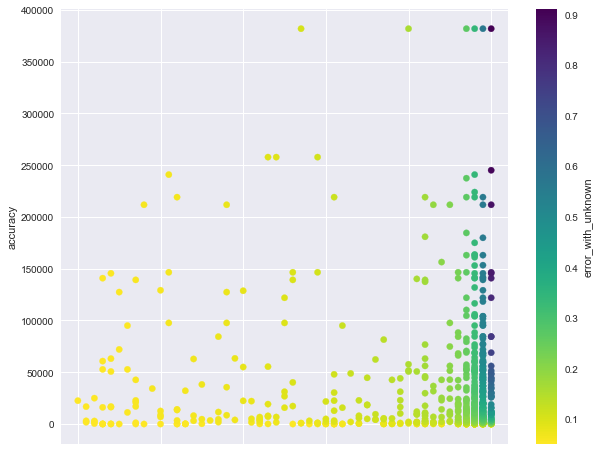

In [69]:
df_error_with_unknown.plot.scatter(x='samples', y='accuracy', c='error_with_unknown', xlim=(48,102), 
                                   cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

Here, we see the expected trend: the higher either of the parameter values, the higher the `error_with_unknown`.

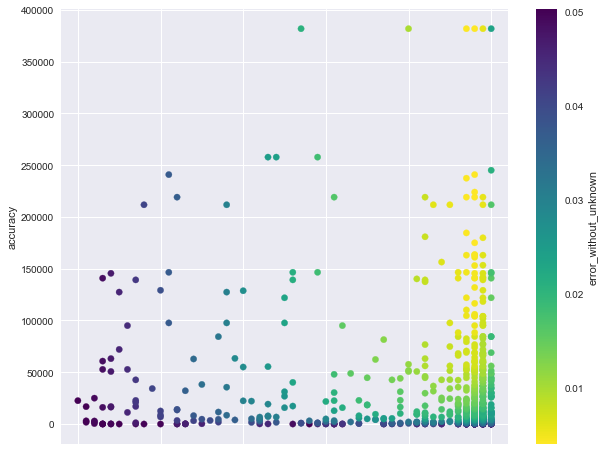

In [70]:
df_error_without_unknown.plot.scatter(x='samples', y='accuracy', c='error_without_unknown', xlim=(48,102), 
                                      cmap=plt.cm.get_cmap('viridis_r'), s=40, figsize=(10,8))

The tendency with the `error_without_unknown` is that the higher both parameter values the lower the error. 
**However, the far right column is not intuitive and needs further exploration.**

## TODO: have a closer look into the wrong classifications